一個前の奴を提出したらNumberChildren列の前処理改善を反映


変数を一個ずつ消して前処理の正確性を確かめる

相関係数が高い変数を対処

In [9]:
# インストール
#!pip install kanjize

# インポート
import pandas as pd
import numpy as np
from kanjize import number2kanji, kanji2number
import re
import unicodedata

# 読み込み
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 結合
train_df['flg'] = -1
test_df['flg'] = -2
df = pd.concat([train_df, test_df], axis=0)





##### 前処理 #####





### Age列 ###



# 歳, 才, 際を削除
df['Age'] = df['Age'].str.replace('歳', '').str.replace('才', '').str.replace('際', '')


# 日本語と数字の年代表記を対応させる
age_mapping = {
    '10代': 15, '20代': 25, '30代': 35, '40代': 45, '50代': 55, '60代': 65,
    '１０代': 15, '２０代': 25, '３０代': 35, '４０代': 45, '５０代': 55, '６０代': 65
}

# マッピングを使ってAge_groupを設定する
df['Age_Group_Generation'] = df['Age'].map(age_mapping)

df['Age'] = df['Age'].replace({
    '10代': -1, '20代': -2, '30代': -3, '40代': -4, '50代': -5, '60代': -6,
    '１０代': -1, '２０代': -2, '３０代': -3, '４０代': -4, '５０代': -5, '６０代': -6
})


# 漢数字を数字に変換
# NaNが含まれている場合のみ処理を実行
if df['Age'].isna().any():
    # NaNを含む行は除外せず、そのまま処理を続ける
    df['Age'] = df['Age'].apply(lambda x: kanji2number(x) if isinstance(x, str) else x)
else:
    # NaNが含まれていない場合、通常通り処理を実行
    df['Age'] = df['Age'].apply(lambda x: kanji2number(x) if isinstance(x, str) else x)

# Age列をfloat型に
df['Age'] = df['Age'].astype(float)


# NaNでないか確認し、Age_Groupに対応
def age_group(age):
    if isinstance(age, float):
        if   10 <= age < 20:
            return '15'
        elif 20 <= age < 30:
            return '25'
        elif 30 <= age < 40:
            return '35'
        elif 40 <= age < 50:
            return '45'
        elif 50 <= age < 60:
            return '55'
        elif 60 <= age < 70:
            return '65'
        else:
          return np.nan

df['Age_Group'] = df['Age'].apply(age_group)

# Age_Group_Generationの値をAge_Groupに代入（NaNの場合は何もしない）
df['Age_Group'] = np.where(df['Age_Group_Generation'].notna(), df['Age_Group_Generation'], df['Age_Group'])

# Age_Group列をfloat型に変更
df['Age_Group'] = df['Age_Group'].astype(float)
'''
# 世代のAgeをあいだの値で埋める
# 元のマッピングを定義
reverse_mapping = {
    -1: 15, -2: 25, -3: 35, -4: 45, -5: 55, -6: 65
}
'''
# 世代のAgeを欠損値にする
reverse_mapping = {
    -1: np.nan, -2: np.nan, -3: np.nan, -4: np.nan, -5: np.nan, -6: np.nan
}
# Age列の値を反転マッピングで置き換え
df['Age'] = df['Age'].replace(reverse_mapping)

# Age_Group_Generation列を削除
df = df.drop(columns=['Age_Group_Generation'])



### TypeofContact列 ###



# 空白を削除
df['TypeofContact'] = df['TypeofContact'].str.replace(' ', '', regex=False)

# nanを欠損値に置き換える
df['TypeofContact'] = df['TypeofContact'].replace('nan', np.nan)

# ワンホットエンコーディング
df = pd.get_dummies(df, columns=['TypeofContact'], prefix='TypeofContact')



### DurationOfPitch列 ###



def convert_duration_to_seconds(duration):
    # NaNの場合はそのまま返す
    if pd.isna(duration):
        return duration
    # 分と秒の形式を判定
    minutes_match = re.match(r'(\d+)分', duration)
    seconds_match = re.match(r'(\d+)秒', duration)

    if minutes_match:
        minutes = int(minutes_match.group(1))
        return minutes * 60
    elif seconds_match:
        seconds = int(seconds_match.group(1))
        return seconds
    else:
        # 他の形式はそのまま返す
        return duration

# 秒数に変換
df['DurationOfPitch'] = df['DurationOfPitch'].apply(convert_duration_to_seconds)



### Occupation列 ###



# ワンホットエンコーディング
df = pd.get_dummies(df, columns=['Occupation'])



### Gender列 ###



# 空白を削除
df['Gender'] = df['Gender'].str.replace(' ', '', regex=False)
df['Gender'] = df['Gender'].str.replace('\u3000', '')

# 大文字を小文字に変換
df['Gender'] = df['Gender'].str.lower()

# 全角を半角に置き換え
df['Gender'] = df['Gender'].replace('ｆｅｍａｌｅ', 'female')
df['Gender'] = df['Gender'].replace('ｍａｌｅ', 'male')

# ワンホットエンコーディング
df = pd.get_dummies(df, columns=['Gender'])



### ProductPitched列 ###



# 空白を削除
df['ProductPitched'] = df['ProductPitched'].str.replace(' ', '', regex=False)

# 変な文字をシンプルな文字に置換
replace_dict = {
    'ᗞ': 'd', '|': 'l', 'ꓢ': 's', 'в': 'b', '×': 'x',
    'ε': 'e', 'β': 'b', 'ϲ': 'c', 'α': 'a', '𝖺': 'a', '𝙳': 'D',
    '𐊡': 'a', '𝘘': 'O', 'ꭰ': 'L', 'ｓ': 's', 'ѕ': 's', 'baѕic': 'basic',
    'ı': 'i', 'ı': 'i', 'l': 'l', 'I': 'l', '𝖽': 'd', '𝑑': 'd'
}

# 置換処理をまとめて適用
for key, value in replace_dict.items():
    df['ProductPitched'] = df['ProductPitched'].str.replace(key, value, regex=False)

# 小文字に変換
df['ProductPitched'] = df['ProductPitched'].str.lower()

# 似ている値のリスト(表記揺れ)
similar_to_basic = [
    'baslc', 'bαslc', 'basi𝘤', 'βasic', 'basiс', 'baտlc', 'вasic',
    'basιc', 'baslс', 'βaslс', 'basιс', 'baѕlc', 'βasi𝘤', 'aasi𝘤', 'aasic',
]

similar_to_standard = [
    'standar𝔡', 'staոdard', 'տtandard', 's𝘵andard', 'standarꭰ',
    'standa𝘳d', 'տtanda𝘳d', 'stan𝔡ard', 'stαndard', 's𝘵anda𝘳d', 'ѕtandard'
]

similar_to_king = [
    'klng', 'kiոg', 'kιng'
]

similar_to_deluxe = [
    'dεluxε', 'deluxε', 'ꭰeluxe'
]

similar_to_superdeluxe = [
    'ѕuperdeluxe', 'superꭰeluxe', 'superdεluxe', 'supεrꭰeluxe', 'տuperdeluxe'
]

# 本来の値に変更
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'basic' if x in similar_to_basic else x)
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'standard' if x in similar_to_standard else x)
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'king' if x in similar_to_king else x)
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'deluxe' if x in similar_to_deluxe else x)
df['ProductPitched'] = df['ProductPitched'].apply(lambda x: 'superdeluxe' if x in similar_to_superdeluxe else x)

# ワンホットエンコーディング
df = pd.get_dummies(df, columns=['ProductPitched'])



### Designation列 ###



# 空白を削除
df['Designation'] = df['Designation'].str.replace(' ', '', regex=False)

# 似ている値のリスト
similar_to_executive = [
    'Execuｔive', 'E×ecutive', 'Executiѵе',
    'Еxecutivе', 'Exеcutivе',
    'Executivе', 'Executiѵе', 'Е×еcutive', 'Еxecutive', 'E×еcutiѵе',
    'Exеcｕtive', 'Execｕtive', 'E×ecｕtive', 'Exеcｕtivе',
    'Еxecuｔive', 'Exеcutive', 'Executiѵe', 'E×еcutiѵe', 'Exеcuｔive', 'Execｕｔive',
    'Execｕtivе', 'Еxecｕtive', 'Еxеcutivе', 'Е×ecutive', 'Exеcutiѵе'
]

similar_to_senior_manager = [
    'SeniorManage𝙝', 'SеniorManager', 'SeniorΜanαger', 'Senio𝙝Manager',
    'SeniorManagе𝙝', 'SеniorManagе𝙝', 'SeniorMαnαger', 'ЅeniorManαger',
    'SeniorMαnage𝙝', 'SеniorManagе𝙝', 'SeniorMαnager', 'Senio𝙝Manαger', 'SeniorManage𝙧',
    'ЅeniorManager', 'SeniorManagе𝙧', 'Senio𝙭Manager', 'SeniorManagеr', 'SeniorManαger',
    'SеniorManagеr', 'SeniorΜanager', 'ЅeniorΜanage𝙝', 'ՏeniorΜanager', 'ՏeniorManager',
    'Senio𝙧Manage𝙧', 'Senio𝙧Manαger', 'ЅeniorΜanage𝙧', 'Senio𝙧Manager', 'Senio𝙧Managеr', 'SеniorManagе𝙧',
    'Senio𝙧Mαnage𝙧', 'Sеnio𝙧Manager'

]

similar_to_avp = [
    'ΑVP', 'АVP', 'AVP', 'AVР', 'AVР', 'AVＰ', 'ΑVP',  'ΑVＰ', 'АVＰ'
]

similar_to_manager = [
    'Μanager', 'Managеr', 'Manαger', 'Mαnagеr', 'Mαnager', 'Mαnаger',
    'Manage𝙝', 'Managе𝙝', 'Mαnage𝙝', 'Mαnage𝙧', 'Manage𝙧', 'Μanage𝙝', 'Manαgеr',
    'Μanage𝙝', 'Manαgеr', 'Mαnαger', 'Μanagеr', 'Managе𝙝',
    'Μanage𝙧', 'Μαnager', 'Μαnagеr', 'Managе𝙧', 'Mαnαgеr'

]

similar_to_vp = [
    'VP', 'VＰ', 'VР'
]

# 本来の値に変更
df['Designation'] = df['Designation'].apply(lambda x: 'Executive' if x in similar_to_executive else x)
df['Designation'] = df['Designation'].apply(lambda x: 'SeniorManager' if x in similar_to_senior_manager else x)
df['Designation'] = df['Designation'].apply(lambda x: 'AVP' if x in similar_to_avp else x)
df['Designation'] = df['Designation'].apply(lambda x: 'Manager' if x in similar_to_manager else x)
df['Designation'] = df['Designation'].apply(lambda x: 'VP' if x in similar_to_vp else x)

# ワンホットエンコーディング
df = pd.get_dummies(df, columns=['Designation'])



### MonthlyIncome列 ###



# 空白を削除
df['MonthlyIncome'] = df['MonthlyIncome'].str.replace(' ', '', regex=False)

# 全角数字を半角数字に変換する関数
def convert_fullwidth_to_halfwidth(value):
    if isinstance(value, str):
        return value.translate(str.maketrans(
            '０１２３４５６７８９',
            '0123456789'
        ))
    return value

# 変換を適用
df['MonthlyIncome'] = df['MonthlyIncome'].apply(convert_fullwidth_to_halfwidth)

def convert_to_yen(value):
    if isinstance(value, str):
        try:
            # 「月収」や「万円」などの単位を削除
            value = value.replace('月収', '').replace('万円', '')
            income = float(value)
            if income < 100000:
                return income * 10000  # 「万円」を「円」に変換
            else:
                return income  # 「円」のまま返す
        except ValueError:
            return np.nan  # 変換できない場合はNaNを返す
    elif isinstance(value, float):
        return value  # float型の場合はそのままスルー
    else:
        return np.nan  # その他の型や欠損値の場合はNaNを返す

# 数値に変換
df['MonthlyIncome'] = df['MonthlyIncome'].apply(convert_to_yen)



### customer_info列 ###



#, 、 ／ / 全角スペースを空白に置き換え
df['customer_info'] = df['customer_info'].str.replace(',', ' ', regex=False)
df['customer_info'] = df['customer_info'].str.replace('、', ' ', regex=False)
df['customer_info'] = df['customer_info'].str.replace('／', ' ', regex=False)
df['customer_info'] = df['customer_info'].str.replace('/', ' ', regex=False)
df['customer_info'] = df['customer_info'].str.replace('\u3000', ' ', regex=False)


# 結果を元に新しい列を作成
df[['marital_status', 'car_ownership', 'children', 'NumberChildren']] = df['customer_info'].str.split(expand=True)


# 元の列を削除
df = df.drop(columns=['customer_info'])


# marital_status列をワンホットエンコーディング
df = pd.get_dummies(df, columns=['marital_status'])


# 車のマッピング
similar_to_1 = [
    '車あり', '自家用車あり', '車所持', '車保有', '乗用車所持', '自動車所有'
]

similar_to_2 = [
    '車未所持', '自動車未所有', '車保有なし', '乗用車なし', '自家用車なし', '車なし'
]
# 本来の値に変更
df['car_ownership'] = df['car_ownership'].apply(lambda x: 1 if x in similar_to_1 else x)
df['car_ownership'] = df['car_ownership'].apply(lambda x: 0 if x in similar_to_2 else x)

# NumberChildren列の'人'を削除
df['NumberChildren'] = df['NumberChildren'].str.replace('人', '', regex=False)

# ユニークな値と対応する数字のマッピング

children_map = {
    '子供なし': 0, '子供無し': 0, '無子': 0, '子供ゼロ': 0, '非育児家庭': 0,
    '子育て状況不明': np.nan, '子の数不詳': np.nan, '子供の数不明': np.nan,
    'こども1人': 1, '1児': 1, '子供1人': 1, '子供有り(1人)': 1,
    'わからない': np.nan, '子供有り': np.nan,
    'こども2人': 2, '子供2人': 2, '子供有り(2人)': 2,
    'こども3人': 3, '子供3人': 3, '不明': np.nan, '2児': 2, '3児': 3,
    '子供有り(3人)': 3
}
'''
children_map = {
    '子供なし': 0, '子供無し': 0, '無子': 0, '子供ゼロ': 0, '非育児家庭': 0,
    '子育て状況不明': np.nan, '子の数不詳': np.nan, '子供の数不明': np.nan,
    'こども1人': 1, '1児': 1, '子供1人': 1, '子供有り(1人)': 1,
    'わからない': np.nan, '子供有り': -1,
    'こども2人': 2, '子供2人': 2, '子供有り(2人)': 2,
    'こども3人': 3, '子供3人': 3, '不明': np.nan, '2児': 2, '3児': 3,
    '子供有り(3人)': 3
}
'''

# NumberChildren列の値を数値に変換
df['children'] = df['children'].map(children_map)
'''
# NumberChildren列の値を数値に変換
df['NumberChildren'] = df.apply(
    lambda row: row['NumberChildren'] if row['children'] == -1 else
    (np.nan if pd.isna(row['children']) else row['children']),
    axis=1
)
'''
df['NumberChildren'] = df['children'].apply(lambda x: x if pd.notna(x) else None)


# children列の値を1または0に変換
#df['children'] = df['children'].map({0: 0, 1: 1, 2: 1, 3: 1})

df['children'] = df['children'].map({0: 0, 1: 1, 2: 1, 3: 1, -1: 1})


### NumberOfTrips列 ###



# マッピング辞書を作成
mapping = {
    '年に1回': 1, '年に2回': 2, '年に3回': 3,  '年に4回': 4,
    '年に5回': 5, '年に6回': 6, '年に7回': 7, '年に8回': 8,
    '半年に1回': 2, '四半期に1回': 4
}

# 数値に変換
df['NumberOfTrips'] = df['NumberOfTrips'].apply(lambda x: mapping.get(x))





##### 特徴量エンジニアリング #####





### Gender_male列とGender_female列(相関係数1) ###



# Gender_female列を削除
df = df.drop(columns=['Gender_female'])



### TypeofContact_CompanyInvited列とTypeofContact_SelfEnquiry列(相関係数1) ###



# 新しい列を作成し、片方の列が1.0であれば1.0を設定
df['TypeofContactMerge'] = (df['TypeofContact_CompanyInvited'] > 0.0) | (df['TypeofContact_SelfEnquiry'] > 0.0)

# 片方を削除(目的変数との相関が弱く、尚且つほかの変数との相関も大きい方)
df.drop(['TypeofContact_CompanyInvited'], axis=1, inplace=True)



### Age列とAge_Group列(相関係数0.96) ###



'''
何もしない
'''



### ProductPitched_deluxe列とDesignation_Manager列(相関係数0.97) ###



# 新しい列を作成し、両方の列が1.0であれば1.0を設定
df['DesignationMerge'] = (df['ProductPitched_deluxe'] > 0.0) & (df['Designation_Manager'] > 0.0)

# Designation_Manager列を削除
df.drop(['Designation_Manager'], axis=1, inplace=True)
# 提出がダメだったら'何もしない'に変更




##### データを再分割して表示 #####



#float型に
df = df.astype(float)

# 再分割
train_df = df[df['flg'] == -1]
test_df = df[df['flg'] == -2]

# flg列を削除
train_df = train_df.drop(columns=['flg'])
test_df = test_df.drop(columns=['flg'])

#すべての列を表示するオプション
pd.set_option('display.max_columns', None)
# データの確認
display(df)
display(train_df)
display(test_df)

,id,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,flg,Age_Group,TypeofContact_SelfEnquiry,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business,Gender_male,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,ProductPitched_standard,ProductPitched_superdeluxe,Designation_AVP,Designation_Executive,Designation_SeniorManager,Designation_VP,car_ownership,children,NumberChildren,marital_status_未婚,marital_status_独身,marital_status_結婚済み,marital_status_離婚済み,TypeofContactMerge,DesignationMerge
0,0.0,50.0,2.0,900.0,1.0,4.0,3.0,NaN,1.0,4.0,253905.0,1.0,-1.0,55.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,56.0,1.0,840.0,1.0,4.0,3.0,NaN,1.0,4.0,404475.0,0.0,-1.0,55.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2.0,NaN,1.0,600.0,1.0,3.0,3.0,NaN,0.0,4.0,278145.0,1.0,-1.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3.0,37.0,2.0,1080.0,1.0,3.0,4.0,NaN,0.0,5.0,326805.0,0.0,-1.0,35.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,4.0,48.0,3.0,1020.0,1.0,3.0,4.0,NaN,0.0,4.0,258435.0,1.0,-1.0,45.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,6973.0,41.0,1.0,840.0,1.0,3.0,3.0,NaN,0.0,4.0,261840.0,NaN,-2.0,45.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3485,6974.0,44.0,1.0,2100.0,3.0,5.0,3.0,NaN,0.0,3.0,349770.0,NaN,-2.0,45.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3486,6975.0,24.0,2.0,1260.0,2.0,3.0,3.0,NaN,0.0,3.0,270000.0,NaN,-2.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3487,6976.0,25.0,1.0,540.0,2.0,3.0,3.0,NaN,0.0,3.0,272430.0,NaN,-2.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


,id,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,Age_Group,TypeofContact_SelfEnquiry,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business,Gender_male,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,ProductPitched_standard,ProductPitched_superdeluxe,Designation_AVP,Designation_Executive,Designation_SeniorManager,Designation_VP,car_ownership,children,NumberChildren,marital_status_未婚,marital_status_独身,marital_status_結婚済み,marital_status_離婚済み,TypeofContactMerge,DesignationMerge
0,0.0,50.0,2.0,900.0,1.0,4.0,3.0,NaN,1.0,4.0,253905.0,1.0,55.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,56.0,1.0,840.0,1.0,4.0,3.0,NaN,1.0,4.0,404475.0,0.0,55.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2.0,NaN,1.0,600.0,1.0,3.0,3.0,NaN,0.0,4.0,278145.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3.0,37.0,2.0,1080.0,1.0,3.0,4.0,NaN,0.0,5.0,326805.0,0.0,35.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,4.0,48.0,3.0,1020.0,1.0,3.0,4.0,NaN,0.0,4.0,258435.0,1.0,45.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,3484.0,40.0,2.0,1560.0,2.0,3.0,3.0,NaN,0.0,1.0,258900.0,1.0,45.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3485,3485.0,NaN,1.0,540.0,3.0,3.0,5.0,NaN,0.0,3.0,260415.0,0.0,45.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
3486,3486.0,31.0,1.0,840.0,3.0,2.0,3.0,NaN,0.0,4.0,317340.0,0.0,35.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3487,3487.0,56.0,2.0,900.0,3.0,6.0,3.0,NaN,1.0,4.0,527910.0,1.0,55.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0


,id,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,Age_Group,TypeofContact_SelfEnquiry,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business,Gender_male,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,ProductPitched_standard,ProductPitched_superdeluxe,Designation_AVP,Designation_Executive,Designation_SeniorManager,Designation_VP,car_ownership,children,NumberChildren,marital_status_未婚,marital_status_独身,marital_status_結婚済み,marital_status_離婚済み,TypeofContactMerge,DesignationMerge
0,3489.0,48.0,2.0,780.0,1.0,4.0,3.0,NaN,0.0,3.0,496950.0,NaN,45.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,3490.0,NaN,2.0,720.0,1.0,4.0,3.0,NaN,1.0,3.0,300000.0,NaN,35.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3491.0,25.0,1.0,540.0,1.0,4.0,3.0,NaN,0.0,3.0,260000.0,NaN,25.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,3492.0,21.0,2.0,420.0,1.0,4.0,4.0,NaN,0.0,3.0,259875.0,NaN,25.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,3493.0,41.0,1.0,420.0,1.0,4.0,3.0,NaN,0.0,4.0,268830.0,NaN,45.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,6973.0,41.0,1.0,840.0,1.0,3.0,3.0,NaN,0.0,4.0,261840.0,NaN,45.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3485,6974.0,44.0,1.0,2100.0,3.0,5.0,3.0,NaN,0.0,3.0,349770.0,NaN,45.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3486,6975.0,24.0,2.0,1260.0,2.0,3.0,3.0,NaN,0.0,3.0,270000.0,NaN,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3487,6976.0,25.0,1.0,540.0,2.0,3.0,3.0,NaN,0.0,3.0,272430.0,NaN,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


Train DataFrame Basic Statistics:


,id,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,Age_Group,TypeofContact_SelfEnquiry,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business,Gender_male,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,ProductPitched_standard,ProductPitched_superdeluxe,Designation_AVP,Designation_Executive,Designation_SeniorManager,Designation_VP,car_ownership,children,NumberChildren,marital_status_未婚,marital_status_独身,marital_status_結婚済み,marital_status_離婚済み,TypeofContactMerge,DesignationMerge
count,3489.000000,3018.000000,3489.000000,3368.000000,3489.000000,3456.000000,3489.000000,500.000000,3489.000000,3489.000000,3433.000000,3489.000000,3389.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3452.000000,3452.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,1744.000000,39.306826,1.697048,860.682898,2.394669,7.765336,3.441101,3.246000,0.102608,2.513901,355671.369065,0.142448,39.983771,0.628833,0.103468,0.401548,0.494984,0.591574,0.331614,0.299513,0.036113,0.241043,0.091717,0.089137,0.329607,0.244769,0.034107,0.488392,0.714658,0.995655,0.166523,0.185153,0.396675,0.251648,0.998280,0.294067
std,1007.331872,9.905852,0.671500,417.261793,0.726612,39.498670,0.599633,1.754891,0.303490,1.115412,75173.253245,0.349559,10.159939,0.483186,0.304613,0.490282,0.500047,0.491613,0.470860,0.458110,0.186599,0.427778,0.288667,0.284983,0.470138,0.430012,0.181531,0.499937,0.451643,0.780250,0.372603,0.388478,0.489278,0.434022,0.041439,0.455688
min,0.000000,18.000000,1.000000,240.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,200000.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,872.000000,32.000000,1.000000,540.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,300000.000000,0.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1744.000000,38.000000,2.000000,780.000000,2.000000,4.000000,3.000000,3.000000,0.000000,2.000000,343140.000000,0.000000,35.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2616.000000,47.000000,2.000000,960.000000,3.000000,4.000000,4.000000,5.000000,0.000000,3.000000,400000.000000,0.000000,45.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,3488.000000,61.000000,3.000000,2160.000000,4.000000,600.000000,5.000000,8.000000,1.000000,5.000000,600000.000000,1.000000,65.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Test DataFrame Basic Statistics:


,id,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,ProdTaken,Age_Group,TypeofContact_SelfEnquiry,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business,Gender_male,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,ProductPitched_standard,ProductPitched_superdeluxe,Designation_AVP,Designation_Executive,Designation_SeniorManager,Designation_VP,car_ownership,children,NumberChildren,marital_status_未婚,marital_status_独身,marital_status_結婚済み,marital_status_離婚済み,TypeofContactMerge,DesignationMerge
count,3489.000000,3082.000000,3489.000000,3358.00000,3489.000000,3465.000000,3489.000000,516.000000,3489.000000,3489.000000,3440.000000,0.0,3396.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3452.000000,3452.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,5233.000000,39.058079,1.682717,875.30673,2.407567,6.849639,3.431929,3.141473,0.095156,2.500143,356591.114826,NaN,39.726148,0.644884,0.103181,0.401261,0.495557,0.617369,0.341072,0.299799,0.045858,0.221553,0.091717,0.092863,0.338206,0.222987,0.041559,0.474348,0.732329,1.030997,0.158785,0.190026,0.419031,0.232158,0.996561,0.292634
std,1007.331872,9.952869,0.671710,427.73201,0.741628,34.890230,0.599618,1.736346,0.293473,1.153904,77118.663103,NaN,10.232141,0.478617,0.304239,0.490224,0.500052,0.486099,0.474137,0.458236,0.209208,0.415352,0.288667,0.290282,0.473167,0.416309,0.199608,0.499413,0.442809,0.777413,0.365528,0.392378,0.493471,0.422270,0.058554,0.455037
min,3489.000000,18.000000,1.000000,240.00000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,200000.000000,NaN,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4361.000000,32.000000,1.000000,540.00000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,300000.000000,NaN,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,5233.000000,38.000000,2.000000,780.00000,2.000000,4.000000,3.000000,3.000000,0.000000,2.000000,340627.500000,NaN,35.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,6105.000000,47.000000,2.000000,1020.00000,3.000000,4.000000,4.000000,4.000000,0.000000,3.000000,400000.000000,NaN,45.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,6977.000000,61.000000,3.000000,2160.00000,4.000000,500.000000,5.000000,8.000000,1.000000,5.000000,600000.000000,NaN,65.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3488
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3489 non-null   float64
 1   Age                         3018 non-null   float64
 2   CityTier                    3489 non-null   float64
 3   DurationOfPitch             3368 non-null   float64
 4   NumberOfPersonVisiting      3489 non-null   float64
 5   NumberOfFollowups           3456 non-null   float64
 6   PreferredPropertyStar       3489 non-null   float64
 7   NumberOfTrips               500 non-null    float64
 8   Passport                    3489 non-null   float64
 9   PitchSatisfactionScore      3489 non-null   float64
 10  MonthlyIncome               3433 non-null   float64
 11  ProdTaken                   3489 non-null   float64
 12  Age_Group                   3389 non-null   float64
 13  TypeofContact_S

None


Test DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3489 entries, 0 to 3488
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3489 non-null   float64
 1   Age                         3082 non-null   float64
 2   CityTier                    3489 non-null   float64
 3   DurationOfPitch             3358 non-null   float64
 4   NumberOfPersonVisiting      3489 non-null   float64
 5   NumberOfFollowups           3465 non-null   float64
 6   PreferredPropertyStar       3489 non-null   float64
 7   NumberOfTrips               516 non-null    float64
 8   Passport                    3489 non-null   float64
 9   PitchSatisfactionScore      3489 non-null   float64
 10  MonthlyIncome               3440 non-null   float64
 11  ProdTaken                   0 non-null      float64
 12  Age_Group                   3396 non-null   float64
 13  TypeofContact_Se

None

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23130 (\N{CJK UNIFIED IDEOGRAPH-5A5A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 29420 (\N{CJK UNIFIED IDEOGRAPH-72EC}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 36523 (\N{CJK UNIFIED IDEOGRAPH-8EAB}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 28168 (\N{CJK UNIFIED IDEOGRAPH-6E08}) missing from current font.
  fig.canvas.draw()
/usr

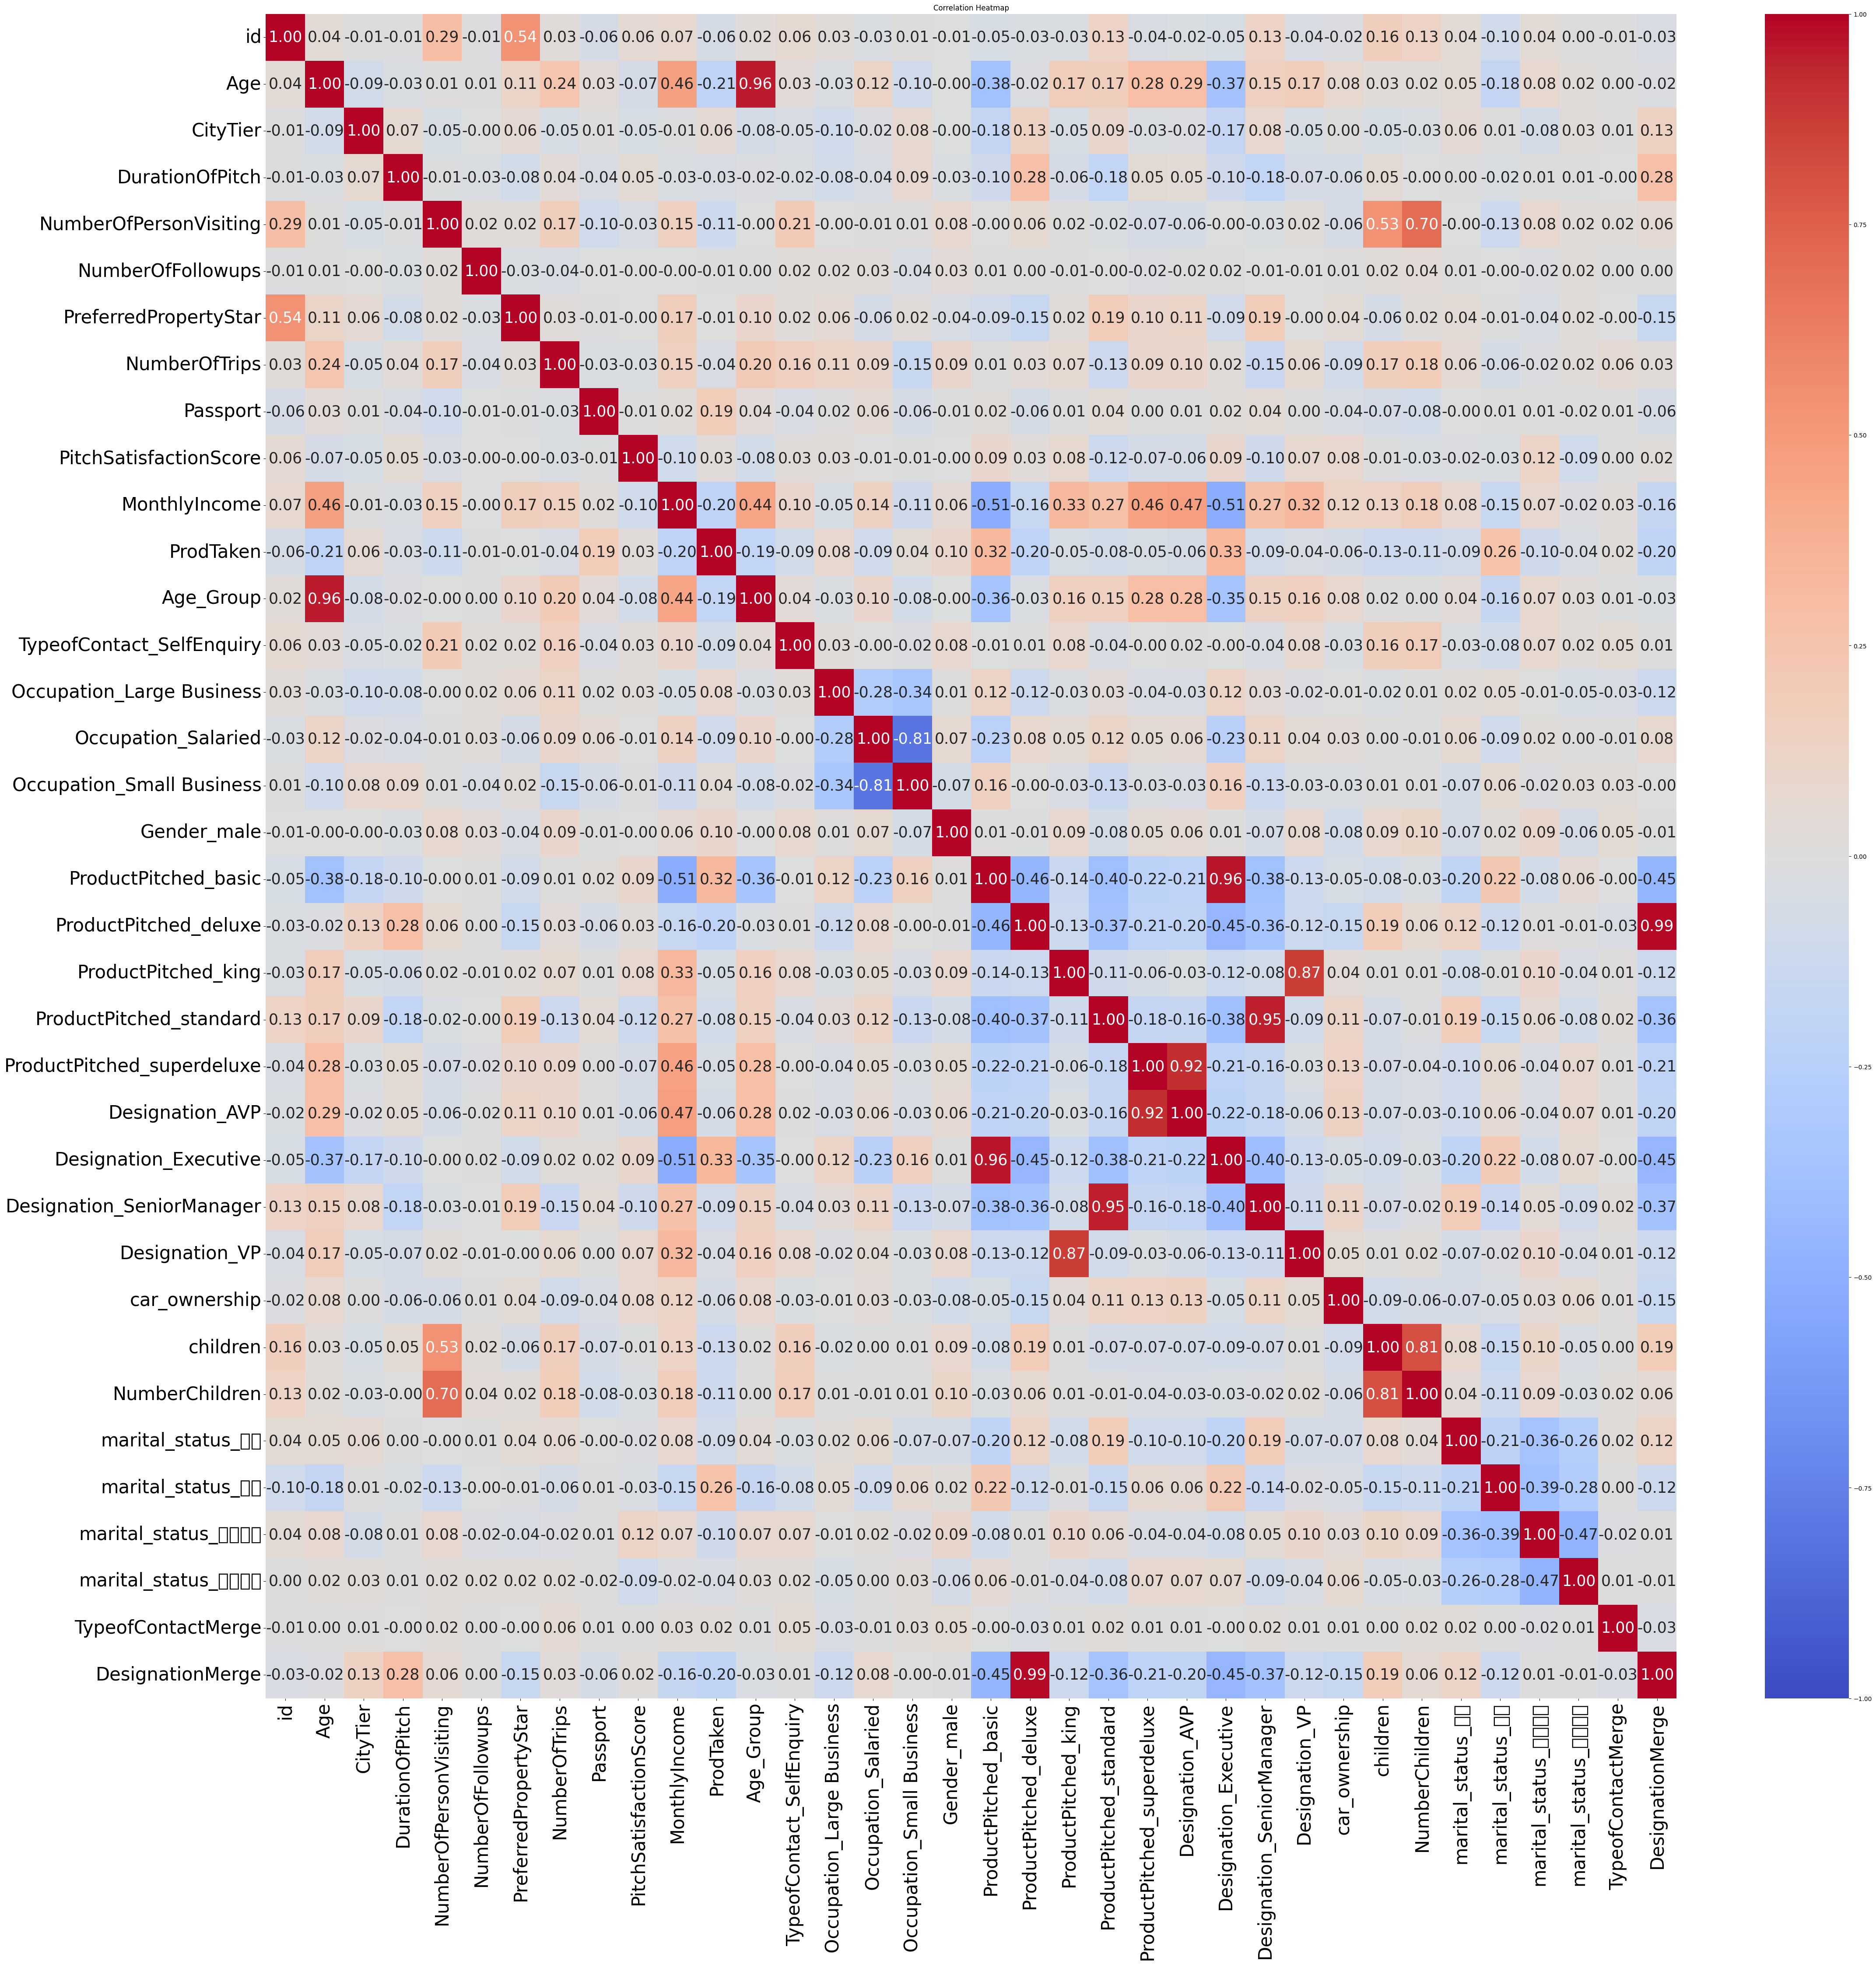

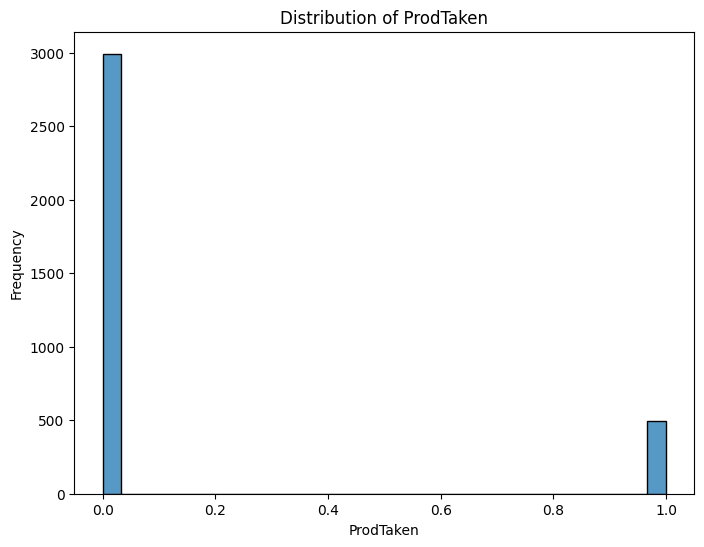

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 基本統計量の表示
print("Train DataFrame Basic Statistics:")
display(train_df.describe())

print("\nTest DataFrame Basic Statistics:")
display(test_df.describe())

# データフレームの情報の表示
print("\nTrain DataFrame Info:")
display(train_df.info())

print("\nTest DataFrame Info:")
display(test_df.info())

# 相関行列の計算
correlation_matrix = train_df.corr()

# ヒートマップの表示
plt.figure(figsize=(52, 50))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 25})
plt.title('Correlation Heatmap')
# 軸ラベルのサイズを調整
plt.xticks(fontsize=30)  # x軸ラベルのサイズ
plt.yticks(fontsize=30)  # y軸ラベルのサイズ
plt.show()

# 目的変数のヒストグラムの表示
plt.figure(figsize=(8, 6))
sns.histplot(train_df['ProdTaken'], kde=False, bins=30)
plt.title('Distribution of ProdTaken')
plt.xlabel('ProdTaken')
plt.ylabel('Frequency')
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 360, number of negative: 2152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 2512, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143312 -> initscore=-1.788049
[LightGBM] [Info] Start training from score -1.788049
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 360, number of negative: 2152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29420 (\N{CJK UNIFIED IDEOGRAPH-72EC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36523 (\N{CJK UNIFIED IDEOGRAPH-8EAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23130 (\N{CJK UNIFIED IDEOGRAPH-5A5A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28168 (\N{CJK UNIFIED IDEOGRAPH-6E08}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

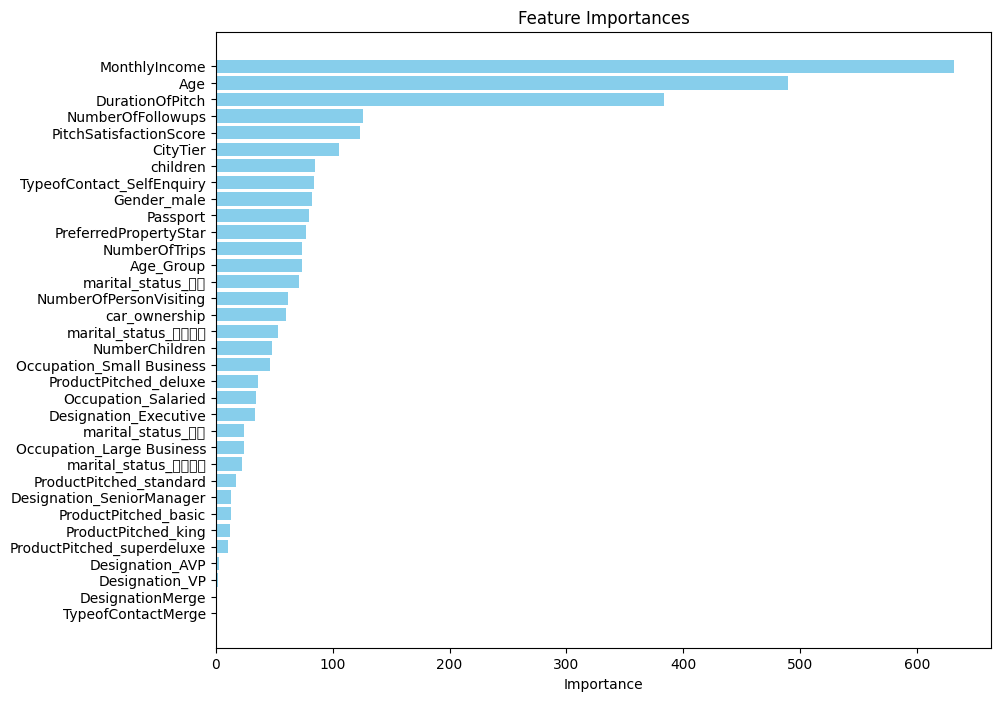

Make_filing_Success!


"\nfrom sklearn.feature_selection import RFE\nfrom sklearn.pipeline import Pipeline\nimport lightgbm as lgb\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.metrics import roc_auc_score\n\n# id列を削除し、目的変数を取り出す\nX = train_df.drop(columns=['id', 'ProdTaken'])\ny = train_df['ProdTaken']\n\n# データの分割\nX_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)\n\n# LightGBMのモデル作成\nmodel = lgb.LGBMClassifier(\n    n_estimators=100,     # デフォルト値\n    learning_rate=0.1,    # デフォルト値\n    num_leaves=31,        # デフォルト値\n    max_depth=-1,         # デフォルト値（無制限）\n    subsample=1.0,        # デフォルト値\n    colsample_bytree=1.0, # デフォルト値\n)\n\n# RFEを使用して特徴量選択\nselector = RFE(model, n_features_to_select=29, step=1)  # n_features_to_selectは選択したい特徴量数\nselector = selector.fit(X_train, y_train)\n\n# 選択された特徴量\nselected_features = X_train.columns[selector.support_]\n\n# LightGBMモデルをRFEで選択した特

In [10]:

from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# id列を削除し、目的変数を取り出す
X = train_df.drop(columns=['id', 'ProdTaken'])
y = train_df['ProdTaken']

# データの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# LightGBMのモデル作成
model = lgb.LGBMClassifier(
    n_estimators=100,     # デフォルト値
    learning_rate=0.1,    # デフォルト値
    num_leaves=31,        # デフォルト値
    max_depth=-1,         # デフォルト値（無制限）
    subsample=1.0,        # デフォルト値
    colsample_bytree=1.0, # デフォルト値
)

# クロスバリデーションでAUCを評価
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

print(f'クロスバリデーションのAUCスコア: {cv_scores.mean():.4f}')

# モデルの訓練
model.fit(X_train, y_train)

# 特徴量の重要度を表示
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# 特徴量の重要度をヒストグラムで表示
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 降順に表示
plt.show()

# テストデータの予測
# 目的変数がテストデータには含まれていないため、予測を行う
test_features = test_df.drop(columns=['id', 'ProdTaken'])
probabilities = model.predict_proba(test_features)

# IDと予測確率のDataFrameを作成
output = pd.DataFrame({
    'id': test_df['id'],
    'probability': probabilities[:, 1]  # クラス1の確率
})

# CSVファイルとして保存（ヘッダー無し）
output.to_csv('SignateCup2024.csv', index=False, header=False)
print('Make_filing_Success!')

'''
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

# id列を削除し、目的変数を取り出す
X = train_df.drop(columns=['id', 'ProdTaken'])
y = train_df['ProdTaken']

# データの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# LightGBMのモデル作成
model = lgb.LGBMClassifier(
    n_estimators=100,     # デフォルト値
    learning_rate=0.1,    # デフォルト値
    num_leaves=31,        # デフォルト値
    max_depth=-1,         # デフォルト値（無制限）
    subsample=1.0,        # デフォルト値
    colsample_bytree=1.0, # デフォルト値
)

# RFEを使用して特徴量選択
selector = RFE(model, n_features_to_select=29, step=1)  # n_features_to_selectは選択したい特徴量数
selector = selector.fit(X_train, y_train)

# 選択された特徴量
selected_features = X_train.columns[selector.support_]

# LightGBMモデルをRFEで選択した特徴量のみで再訓練
model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    subsample=1.0,
    colsample_bytree=1.0,
)

# 訓練データと検証データを選択された特徴量でフィルタリング
X_train_selected = X_train[selected_features]
X_valid_selected = X_valid[selected_features]

# クロスバリデーションでAUCを評価
cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='roc_auc')
print(f'クロスバリデーションのAUCスコア: {cv_scores.mean():.4f}')

# モデルの訓練
model.fit(X_train_selected, y_train)

# 特徴量の重要度を表示
importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# 特徴量の重要度をヒストグラムで表示
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 降順に表示
plt.show()

# テストデータの予測
test_features = test_df.drop(columns=['id', 'ProdTaken'])
test_features_selected = test_features[selected_features]
probabilities = model.predict_proba(test_features_selected)

# IDと予測確率のDataFrameを作成
output = pd.DataFrame({
    'id': test_df['id'],
    'probability': probabilities[:, 1]  # クラス1の確率
})

# CSVファイルとして保存（ヘッダー無し）
output.to_csv('SignateCup2024.csv', index=False, header=False)
print('Make_filing_Success!')
'''